In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
 
from funciones import *
from solvers_listos import *
# from instancia import ubis, cap_tpte, info_locales
# from instancia import G, color_nodos, color_arcos, ancho_edges
from ruteo_alns import ruteo_ALNS

random.seed(1)
np.random.seed(1)

{0: 0, 1: 91, 2: 27, 3: 11, 4: 63, 5: 69, 6: 67, 7: 91, 8: 46, 9: 73, 10: 66}


# Instancia

In [3]:
# G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo= 'n30empty.xlsx' ,plot=True)
# for nodo in G.nodes(data=True):
#     si_o_no = random.randint(0,1)
#     if False and nodo[0] != 'N_0':
#         up = nodo[1]['Up']
#         new_d = random.randint(int(up*0.25), int(up*0.75))
#         G.nodes[nodo[0]]['Prod'] = new_d
#         G.nodes[nodo[0]]['Inv'] = up - new_d

#     print(G.nodes(data=True)[nodo[0]])

In [4]:
# def reaccion_inventario(grafo, mu, sd, alfa = 0.05):
#     """
#     Función que verifica que locales deben ser visitados en base a su inventario actual. 
#     En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
#     """
#     grafo = G.copy()
#     visitas = {nodo : False for nodo in G.nodes()}
#     for nodo in grafo.nodes(data=True):
#         id_nodo = int(nodo[0][2:])-1
#         media = mu[id_nodo]
#         desviacion = sd[id_nodo]
#         s = media + norm.ppf((1 - alfa)/2) * desviacion  #Stock de segrafouridad
#         if nodo[1]['Inv'] <= s:
#             visitas[nodo[0]] = True
    
#     return visitas

In [5]:
#ejemplo demanda historica
muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido=0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    print(demanda)
    print(dem_historico.keys())
    plt.figure(figsize=(10, 5))
    plt.plot(demanda.values(), 'o', color='black') 
    # for nodo in dem_historico.keys():
    #     if nodo != 'N_0':
    #         # plt.plot(dem_historico[nodo])
    #         plt.plot(smooth(dem_historico[nodo], 10))
    plt.xlabel('Días')
    plt.ylabel('Demanda')
    plt.xticks(np.arange(len(demanda)), demanda.keys())
    plt.title('Demanda histórica')
    plt.show()


In [6]:
muestra = False
if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido = 0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    data = {nodo: dem_historico[nodo][1:] for nodo in dem_historico.keys()}
    y = [SEDA(data[nodo], historia=False, alpha = 0.5) for nodo in data.keys()]
    medias = [np.mean(data[nodo]) for nodo in data.keys()]
    ind = np.arange(len(y))

    # y = [SEDA(dem_historico[nodo], pron=True, alpha = 0.5) for nodo in set(dem_historico)-set(['N_0'])]
    # medias = [np.mean(dem_historico[nodo]) for nodo in set(dem_historico)-set(['N_0'])]
    # ind = np.arange(len(y))
    
    # print(y)
    ancho = 0.3
    plt.figure(figsize=(10, 5))
    plt.plot(y, 'o', label='Pronóstico', color='red')
    plt.plot(medias, 'o', label='Promedio', color='blue')
    plt.plot(demanda.values(), 'o', label='Realización', color='black')
    # plt.bar(ind, y, width=ancho, label='Pronóstico', color='red')
    # plt.bar(ind + ancho, medias, width=ancho, label='Promedio', color='blue')
    plt.xticks(ind + ancho / 2, [f'N_{i}' for i in range(1,len(y)+1)])

    plt.xlabel('Local')
    plt.ylabel('Demanda')
    plt.title('Demanda: Pronóstico y realización para t+1')
    plt.legend()
    plt.show()

In [7]:


# Gprima, d, ins = realizacion_demanda(G)

# for nodo in Gprima.nodes(data=True):
#     print(nodo[0],nodo[1]['Inv'])

# def proactiva_inventario(G, pronostico, mu, sd, alfa = 0.05, tolerancia = 0.5):
#     """
#     Función que verifica que locales deben ser visitados en base a su inventario. 
#     En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
#     """
#     visitas = {nodo : False for nodo in G.nodes()}
#     for nodo in G.nodes(data=True):
#         id_nodo = int(nodo[0][2:])-1
#         media = mu[id_nodo]
#         desviacion = sd[id_nodo]
#         s = media + norm.ppf((1 - alfa)/2)* desviacion  #Stock de seguridad
#         if nodo[1]['Inv'] <= s:
#             visitas[nodo[0]] = True
            
#     for nodo in G.nodes(data=True):
#         mean = nodo[1]['Prod'] + mu
#         sd = nodo[1]['Prod'] * sigma
#         l_inf, l_sup = IC_nrm(mean, sd, alfa = 0.95)
#         pronostico = l_sup
#         if nodo[1]['Inv'] - pronostico <= tolerancia * nodo[1]['Up']:
#             visitas[nodo[0]] = True
    
#     return visitas

In [8]:
# dem_historico_test = simular_demanda_previa(G, dist = 'n', T=1000) 
# mu_d = [np.mean(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]    
# sd_d = [np.std(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]
# vis = reaccion_inventario(G, mu_d, sd_d)
# np.sum(mu_d)

In [9]:
def generar_ruta(G, matriz_dst, nodos_a_visitar, cap):
    rutas_NN = nearest_neighbor(
        G, dist_matrix=matriz_dst, disponibilidad = nodos_a_visitar, cap = cap
    )
    # print( "Ruta NN: ")
    # print(rutas_NN[0])
    rutas_2opt = [two_opt(ruta, matriz_dst, 1000) for ruta in rutas_NN]
    # print( "Ruta 2O: ", rutas_2opt[0])
    # rutas = [rutas_NN[0], rutas_2opt[0]]
    # largo = calcular_largo_ruta(rutas[1], matriz_dst)
    rutas = rutas_2opt[0]
    largo = calcular_largo_ruta(rutas, matriz_dst)
    return rutas, largo  # retornamos la ruta 2opt y su largo

In [10]:
def simular_ejecucion_R(grafo_inicial, dem_historico, capacidad,T=1):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [[G0.nodes(data=True)[i]['Inv'] for i in ubicaciones]] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : [] for t in range(T)} # Lista de rutas

    inventario_total = []
    perdidas = []
    # costo_rutas = 0
    # costo_SO = 0
    costo_rutas =[]
    costo_SO = []
    demandas_efectivas = []
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        mu_demanda = [np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()]    
        sd_demanda = [np.std(dem_historico[nodo]) for nodo in dem_historico.keys()]
        # pronostico = [pronostico_SEDA(dem_historico[nodo], T = 10, pron = True, alpha=0.1, beta=0.1, theta=0.5) for nodo in dem_historico.keys()]

        # Estrategia Reactiva (R)  
        # print([G0.nodes(data=True)[i]['Inv'] for i in ubicaciones])
        visitas_reaccion = reaccion_inventario(G0, mu_demanda, sd_demanda)
        # print("Visitas reacción: ", visitas_reaccion)
        if sum(visitas_reaccion.values()) == 0:
            print("No hay locales que visitar")
            rutas[t] = []
            costo_rutas.append(0)

        else:    
            ruta_R, largo_ruta_R = generar_ruta(G0, matriz_dst, visitas_reaccion, cap = capacidad) #devuelve la ruta a realizar
            rutas[t] = ruta_R
            print(f"Ruta {t}: ", ruta_R )
            G0, stock = ejecutar_ruta(G0, ruta_R, matriz_dst)
            costo_rutas.append(largo_ruta_R)
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        demandas_efectivas.append(demanda)
        costo_SO.append(insatisfecho)
        inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones if i != 'N_0']
        inventario_total.append(sum(inventarios))
        perdidas.append(insatisfecho)

        # inventarios.append([G0.nodes(data=True)[i]['Inv'] for i in ubicaciones])
        
        # costo = sum([h[i]*inventarios[i] for i in range(len(inventarios))])
        
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])


    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {sum(perdidas)} | Demanda perdida promedio: {sum(perdidas)/T}')
    print(f'Costo ruta: {costo_rutas} | Costo SO: {costo_SO}')
    costo = costo_SO, costo_rutas
    return rutas, perdidas, inventario_total, costo, demandas_efectivas
        
        
# mis_rutas, dem_historico = simular_ejecucion_R(grafo_inicial = G, T = 365)
        

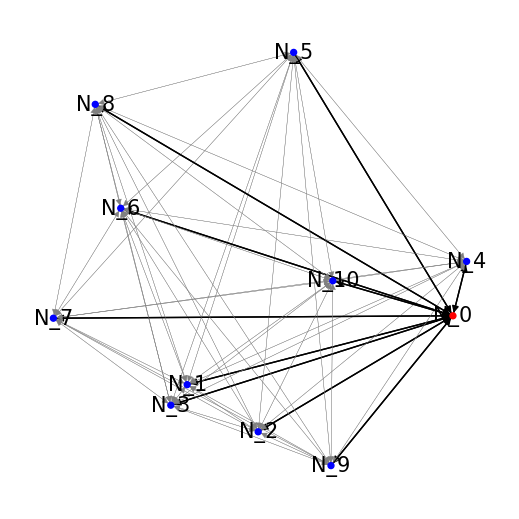

Inventario inicial: 
N_0 1428
N_1 87
N_2 27
N_3 20
N_4 55
N_5 142
N_6 69
N_7 158
N_8 86
N_9 77
N_10 126


No hay locales que visitar
Ruta 1:  ['N_0', 'N_4', 'N_10', 'N_9', 'N_2', 'N_1', 'N_3', 'N_7', 'N_6', 'N_8', 'N_5', 'N_0']
Ruta 2:  ['N_0', 'N_1', 'N_0']
Ruta 3:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_3', 'N_6', 'N_8', 'N_5', 'N_0']
Ruta 4:  ['N_0', 'N_4', 'N_10', 'N_2', 'N_1', 'N_7', 'N_0']
Ruta 5:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_3', 'N_6', 'N_0']
Ruta 6:  ['N_0', 'N_4', 'N_10', 'N_2', 'N_1', 'N_8', 'N_5', 'N_0']
Ruta 7:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_1', 'N_7', 'N_6', 'N_0']
Ruta 8:  ['N_0', 'N_4', 'N_10', 'N_3', 'N_8', 'N_0']
Ruta 9:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_1', 'N_7', 'N_6', 'N_5', 'N_0']
Ruta 10:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_1', 'N_3', 'N_0']
Ruta 11:  ['N_0', 'N_4', 'N_10', 'N_1', 'N_6', 'N_8', 'N_5', 'N_0']
Ruta 12:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_7', 'N_0']
Ruta 13:  ['N_0', 'N_10', 'N_1', 'N_3', 'N_6', 'N_8', 'N_5', 'N_0']
Ruta 14:  ['N_0', 'N_4', 'N_9', 'N_2', 'N

In [11]:
# G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo= 'IRP1.xlsx' ,plot=True)
# historia = simular_demanda_previa(G, dist = 'n', T=1000) 
# mis_rutas, perdidas, inv, costos = simular_ejecucion_R(grafo_inicial = G, dem_historico=historia, capacidad=cap_tpte, T = 30)

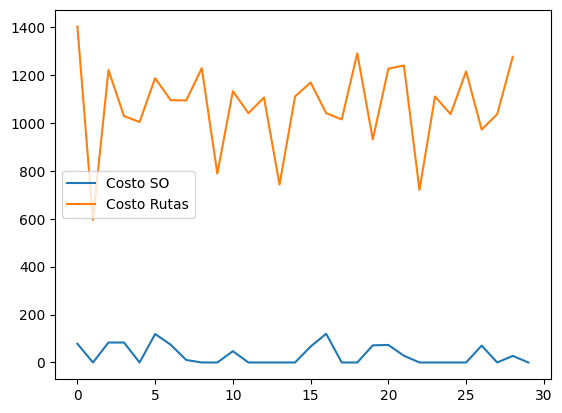

In [15]:
# costo_SO, costo_rutas = costos[0] ,costos[1]
# plt.plot(costo_SO, label = 'Costo SO')
# plt.plot(costo_rutas, label = 'Costo Rutas')
# plt.legend()

In [46]:
# G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo= 'IRP1.xlsx' ,plot=False)
# historia = simular_demanda_previa(G, dist = 'n', T=1000) 
# mis_rutas, perdidas, inv, costos = simular_ejecucion_R(grafo_inicial = G, dem_historico=historia, capacidad=cap_tpte, T = 30)

Inventario inicial: 
N_0 1428
N_1 87
N_2 27
N_3 20
N_4 55
N_5 142
N_6 69
N_7 158
N_8 86
N_9 77
N_10 126


No hay locales que visitar
Ruta 1:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_1', 'N_3', 'N_6', 'N_8', 'N_5', 'N_0']
Ruta 2:  ['N_0', 'N_9', 'N_10', 'N_6', 'N_7', 'N_0']
Ruta 3:  ['N_0', 'N_4', 'N_2', 'N_1', 'N_0']
Ruta 4:  ['N_0', 'N_4', 'N_10', 'N_9', 'N_3', 'N_6', 'N_8', 'N_5', 'N_0']
Ruta 5:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_1', 'N_7', 'N_6', 'N_0']
Ruta 6:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_10', 'N_5', 'N_0']
Ruta 7:  ['N_0', 'N_4', 'N_9', 'N_1', 'N_3', 'N_6', 'N_8', 'N_0']
Ruta 8:  ['N_0', 'N_4', 'N_2', 'N_7', 'N_0']
Ruta 9:  ['N_0', 'N_4', 'N_10', 'N_9', 'N_1', 'N_3', 'N_6', 'N_5', 'N_0']
Ruta 10:  ['N_0', 'N_4', 'N_2', 'N_6', 'N_8', 'N_7', 'N_0']
Ruta 11:  ['N_0', 'N_4', 'N_10', 'N_9', 'N_2', 'N_1', 'N_3', 'N_6', 'N_0']
Ruta 12:  ['N_0', 'N_9', 'N_1', 'N_7', 'N_5', 'N_0']
Ruta 13:  ['N_0', 'N_4', 'N_10', 'N_9', 'N_2', 'N_3', 'N_6', 'N_8', 'N_0']
Ruta 14:  ['N_0', 'N_4', 'N_1', 'N_7', 'N

In [13]:
# def simular_ejecucion_P_LS(grafo_inicial = G, T=1, F=1, cap = cap_tpte):
#     # Inicializar variables     
#     # ---------------------
#     G0 = grafo_inicial.copy()
#     matriz_dst = calcular_matriz_dist(G0)
#     ubicaciones = list(G0.nodes()) # Lista de ubicaciones
#     inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
#     h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
#     rutas = {t : None for t in range(T)} # Lista de rutas
#     dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
#     perdido = 0
#     print("Inventario inicial: ")
#     for nodo in G0.nodes(data=True):
#             print(nodo[0],nodo[1]['Inv'])
#     print("\n")

#     for t in range(T):
#         pronostico = {int(nodo[2:]):
#                 pronostico_SEDA(dem_historico[nodo], T = 1, pron = True, alpha=0.2, beta=0.1, theta=0.5)[0]
#                 for nodo in dem_historico.keys()}
#         # print(pronostico)
         
#         ruta_P = ruteo_ALNS(G0, pronostico, cap = cap, F = F, ruta = True, MRT = 10) + ['N_0']
#         rutas[t] = ruta_P
#         print(f"Ruta {t}: ", ruta_P )
#         # visitas_proactiva = proactiva_inventario(G0, tolerancia = 0.2, dist = 'n', mu = 0, sigma = 0.1, M = 1000)

#         G0, stock = ejecutar_ruta(G0, ruta_P, matriz_dst)
#         G0, demanda, insatisfecho = realizacion_demanda(G0)
        
#         perdido += insatisfecho

#         #Actualizo demandas
#         for nodo in ubicaciones:
#             if nodo != 'N_0':
#                 dem_historico[nodo].append(demanda[nodo])


#     print('\n')
#     print("Inventario final: ")
#     for nodo in G0.nodes(data=True):
#         print(nodo[0],nodo[1]['Inv'])
#     print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')        

#     graficar_rutas(rutas, G0)

# # simular_ejecucion_P(grafo_inicial = G, T = 5, cap = 871)

In [14]:
from ruteo_alns import ruteo_ALNS
cap_tpte = 871
def simular_ejecucion_P_ALNS(grafo_inicial, T=1, F=1, cap = cap_tpte):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : None for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        pronostico = {int(nodo[2:]):
                pronostico_SEDA(dem_historico[nodo], T = 1, pron = True, alpha=0.2, beta=0.1, theta=0.5)[0]
                for nodo in dem_historico.keys()}
        # print(pronostico)
         
        ruta_P = ruteo_ALNS(G0, pronostico, cap = cap, F = F, ruta = True, MRT = 10) + ['N_0']
        rutas[t] = ruta_P
        print(f"Ruta {t}: ", ruta_P )
        # visitas_proactiva = proactiva_inventario(G0, tolerancia = 0.2, dist = 'n', mu = 0, sigma = 0.1, M = 1000)

        G0, stock = ejecutar_ruta(G0, ruta_P, matriz_dst)
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        
        perdido += insatisfecho

        #Actualizo demandas
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])


    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')        

    graficar_rutas(rutas, G0)

# simular_ejecucion_P_ALNS(grafo_inicial = G, T = 5, cap = 871)